In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [3]:

# For add a DAY(int) column 

df = pd.read_csv('../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_19_india.csv')


df['Date'] = pd.to_datetime(df['Date'])

# Find the starting date (Day 0)
start_date = df['Date'].min()

# Create the new 'Day' column
# Subtract start_date from the Date column and extract the number of days
df['Day'] = (df['Date'] - start_date).dt.days

# Save the result to a new file
df.to_csv('covid_data_updated.csv', index=False)

print(df[['Date', 'Day']].head())

        Date  Day
0 2020-01-30    0
1 2020-01-31    1
2 2020-02-01    2
3 2020-02-02    3
4 2020-02-03    4


In [4]:
# 1. Load the file
df = pd.read_csv('covid_data_updated.csv')

# 2. Drop the useless columns immediately
df = df.drop(columns=['ConfirmedIndianNational', 'ConfirmedForeignNational'])

# 3. List of remaining numeric columns we want to sum
numeric_cols = ['Cured', 'Deaths', 'Confirmed']

# 4. Clean the remaining columns
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# (Step 5 is skipped because 'covid_data_updated.csv' already has the Day column)

# 6. Aggregate by Day (Total/Cumulative)
df_aggregated = df.groupby(['Date', 'Day'])[numeric_cols].sum().reset_index()

# --- NEW STEP: Add "New" columns (Daily Increase) ---
for col in numeric_cols:
    # This creates 'New_Cured', 'New_Deaths', 'New_Confirmed'
    # .diff() calculates: (Row N) - (Row N-1)
    df_aggregated[f'New_{col}'] = df_aggregated[col].diff().fillna(0)

# 7. Save
df_aggregated.to_csv('covid_data_clean_with_new_cases.csv', index=False)

print("Saved 'covid_data_clean_with_new_cases.csv'.")
print(df_aggregated.tail())

Saved 'covid_data_clean_with_new_cases.csv'.
           Date  Day     Cured  Deaths  Confirmed  New_Cured  New_Deaths  \
555  2021-08-07  555  31055861  427371   31895385    40017.0       617.0   
556  2021-08-08  556  31099771  427862   31934455    43910.0       491.0   
557  2021-08-09  557  31139457  428309   31969954    39686.0       447.0   
558  2021-08-10  558  31180968  428682   31998158    41511.0       373.0   
559  2021-08-11  559  31220981  429179   32036511    40013.0       497.0   

     New_Confirmed  
555        38628.0  
556        39070.0  
557        35499.0  
558        28204.0  
559        38353.0  


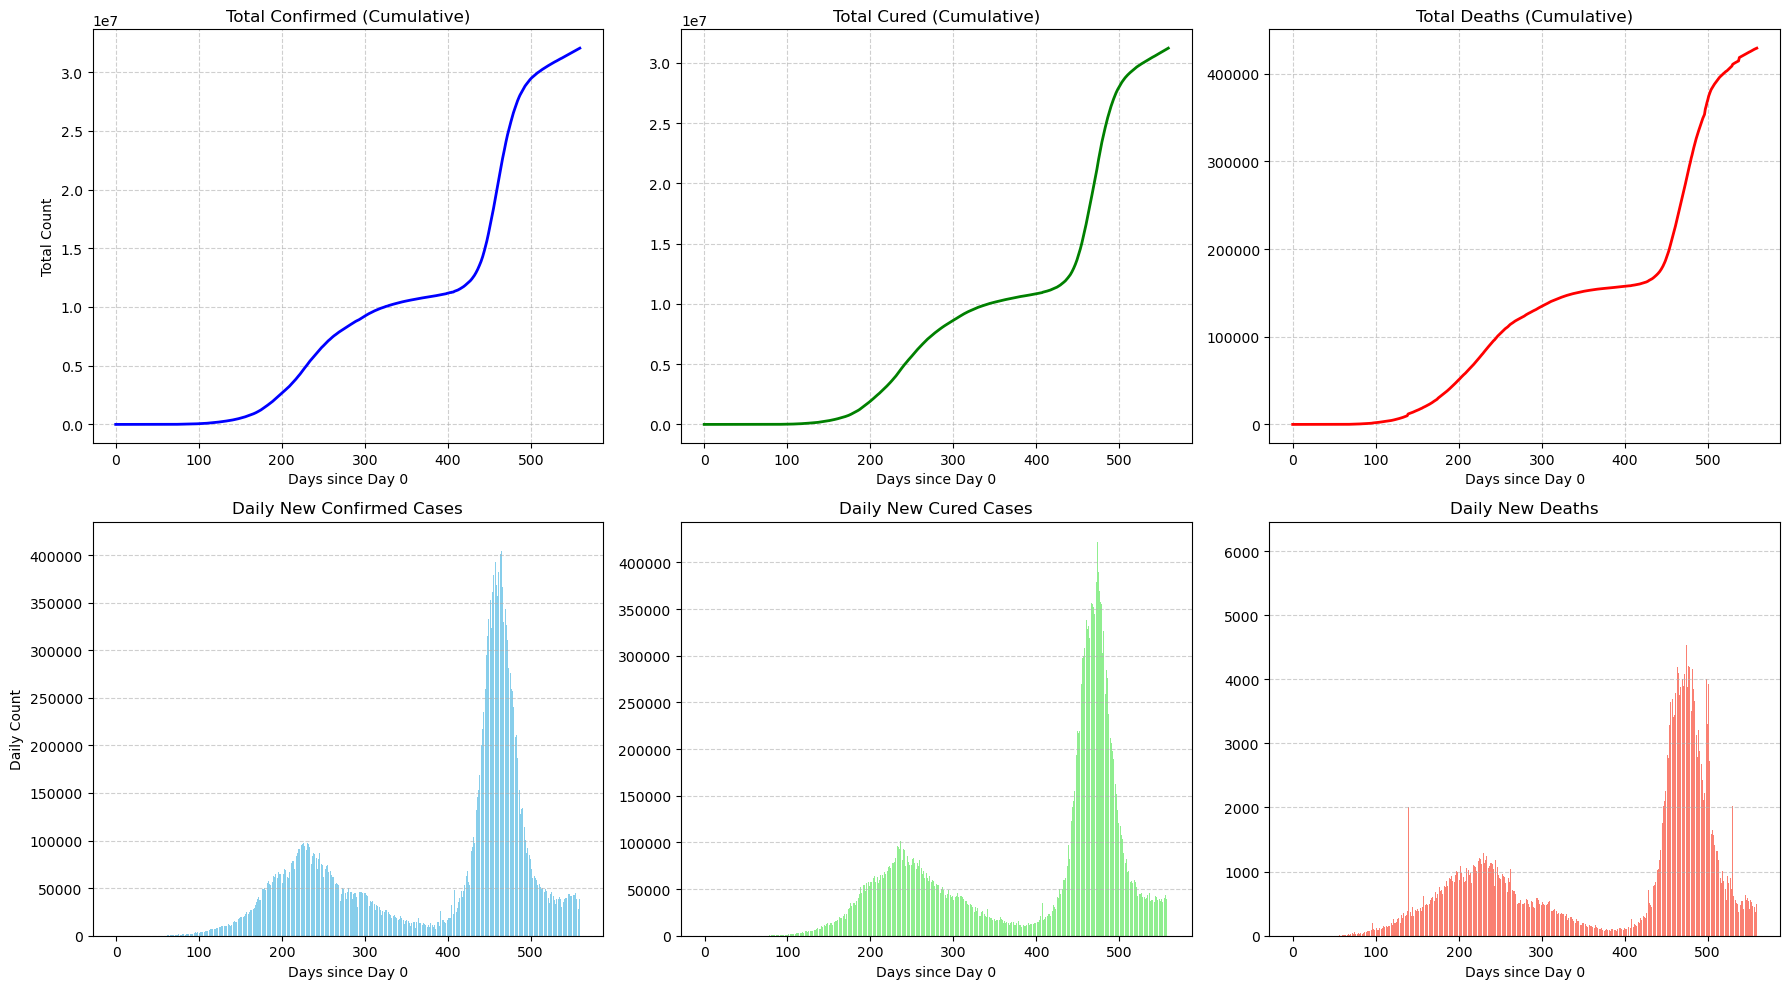

In [5]:
plt.figure(figsize=(18, 10))

# --- ROW 1: TOTALS (Line Charts) ---

# Plot 1: Total Confirmed
plt.subplot(2, 3, 1)
plt.plot(df_aggregated['Day'], df_aggregated['Confirmed'], color='blue', linewidth=2)
plt.title('Total Confirmed (Cumulative)')
plt.xlabel('Days since Day 0')
plt.ylabel('Total Count')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Total Cured
plt.subplot(2, 3, 2)
plt.plot(df_aggregated['Day'], df_aggregated['Cured'], color='green', linewidth=2)
plt.title('Total Cured (Cumulative)')
plt.xlabel('Days since Day 0')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 3: Total Deaths
plt.subplot(2, 3, 3)
plt.plot(df_aggregated['Day'], df_aggregated['Deaths'], color='red', linewidth=2)
plt.title('Total Deaths (Cumulative)')
plt.xlabel('Days since Day 0')
plt.grid(True, linestyle='--', alpha=0.6)

# --- ROW 2: DAILY NEW CASES (Bar Charts) ---

# Plot 4: New Confirmed
plt.subplot(2, 3, 4)
plt.bar(df_aggregated['Day'], df_aggregated['New_Confirmed'], color='skyblue')
plt.title('Daily New Confirmed Cases')
plt.xlabel('Days since Day 0')
plt.ylabel('Daily Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Plot 5: New Cured
plt.subplot(2, 3, 5)
plt.bar(df_aggregated['Day'], df_aggregated['New_Cured'], color='lightgreen')
plt.title('Daily New Cured Cases')
plt.xlabel('Days since Day 0')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Plot 6: New Deaths
plt.subplot(2, 3, 6)
plt.bar(df_aggregated['Day'], df_aggregated['New_Deaths'], color='salmon')
plt.title('Daily New Deaths')
plt.xlabel('Days since Day 0')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [1]:
# ==========================================
# USER INPUT: Change this value (0.1 to 0.99)
user_fraction = 0.9 
# ==========================================

# 1. Load Data
df = pd.read_csv('covid_data_clean_with_new_cases.csv')

# 2. Setup Targets
targets = ['Confirmed', 'Cured', 'Deaths', 'New_Confirmed', 'New_Cured', 'New_Deaths']

# 3. Setup Grid (2 Rows, 3 Columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

print(f"--- Analysis using First {user_fraction*100:.0f}% of Data ---")

# 4. Loop through each data type
for i, target in enumerate(targets):
    
    # A. Split Data based on user_fraction
    n_total = len(df)
    cut_index = int(n_total * user_fraction)
    
    # Safety check: need at least 2 points to train
    if cut_index < 2: cut_index = 2
        
    train_df = df.iloc[:cut_index]
    test_df = df.iloc[cut_index:] # The "Future"
    
    # B. Train Model
    X_train = train_df[['Day']]
    y_train = train_df[target]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # C. Predict (Full timeline to show the line)
    # We use a DataFrame to avoid warnings
    pred_input = df[['Day']]
    predictions = model.predict(pred_input)
    
    # D. Calculate Accuracy (R2 Score) on the unseen future
    score_str = "N/A"
    if len(test_df) > 1:
        X_test = test_df[['Day']]
        y_test = test_df[target]
        y_pred_test = model.predict(X_test)
        score = r2_score(y_test, y_pred_test)
        score_str = f"{score:.4f}"
    
    # Print result
    print(f"{target:<15} | Accuracy (R2): {score_str}")

    # E. Plot
    ax = axes[i]
    
    # Plot 1: The "Future" (Unknown to model) - Gray
    ax.scatter(df['Day'], df[target], color='lightgray', s=50, label='Future (Test)')
    
    # Plot 2: The "History" (Known to model) - Blue
    ax.scatter(train_df['Day'], train_df[target], color='blue', s=50, label='Training Data')
    
    # Plot 3: The Prediction Line - Red
    ax.plot(df['Day'], predictions, color='red', linestyle='--', linewidth=2, label='Prediction')
    
    # Draw a vertical line where the training stopped
    ax.axvline(x=cut_index, color='green', linestyle=':', alpha=0.7)
    
    ax.set_title(f'{target} (Acc: {score_str})')
    ax.set_xlabel('Day')
    ax.grid(True, alpha=0.3)
    
    # Only add legend to the first plot to keep it clean
    if i == 0:
        ax.legend()

plt.suptitle(f"Linear Regression Predictions (Trained on first {user_fraction*100:.0f}%)", fontsize=16)
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined